# Regression TF

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Load Dataset
df = pd.read_csv('dataset/final_df.csv')

# Feature Engineering: Calculate BMI
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2

# Select Features and Target
features = ['gender', 'bmi', 'age']
target = 'daily_steps'

# Map Gender to Numeric Values
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# Prepare X and y
X = df[features]
y = df[target]

# Round target values to nearest hundred
y = (np.round(y / 100) * 100).astype(int)

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale Target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [3]:
# Model Architecture 
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)), 
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1)
])

In [4]:
# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics=["mae"])

In [5]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)

In [6]:
# Train Model
history = model.fit(
    X_train_scaled, y_train_scaled, 
    epochs=100, 
    validation_split=0.2, 
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.9929 - mae: 0.6206 - val_loss: 0.3199 - val_mae: 0.2279 - learning_rate: 0.0010
Epoch 2/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.3546 - mae: 0.3201 - val_loss: 0.2233 - val_mae: 0.2464 - learning_rate: 0.0010
Epoch 3/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2901 - mae: 0.2943 - val_loss: 0.1712 - val_mae: 0.1830 - learning_rate: 0.0010
Epoch 4/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2724 - mae: 0.2851 - val_loss: 0.1517 - val_mae: 0.1782 - learning_rate: 0.0010
Epoch 5/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2518 - mae: 0.2742 - val_loss: 0.2440 - val_mae: 0.3199 - learning_rate: 0.0010
Epoch 6/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2533 - mae: 0.2803 - val_loss: 0.1540 - val_mae: 0.2120 - learning_rate: 0.0010
Epoch 7/100
1870/1870 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.2386 - mae: 0.2691 - val_loss: 0.1588 - val_mae: 0.1556 - learni

In [7]:
# Evaluate Model
test_loss, test_mae = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0181 - mae: 0.0554
Test Loss: 0.0179, Test MAE: 0.0546


In [8]:
# Make Predictions and Calculate Accuracy
y_pred = model.predict(X_test_scaled)
y_pred_rounded = (np.round(scaler_y.inverse_transform(y_pred) / 100) * 100).astype(int)
y_test_rounded = (np.round(y_test.values / 100) * 100)
accuracy = np.mean(np.abs(y_pred_rounded.flatten() - y_test_rounded) <= 100) * 100
print(f"Rounded Accuracy: {accuracy:.2f}%")

585/585 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Rounded Accuracy: 93.58%


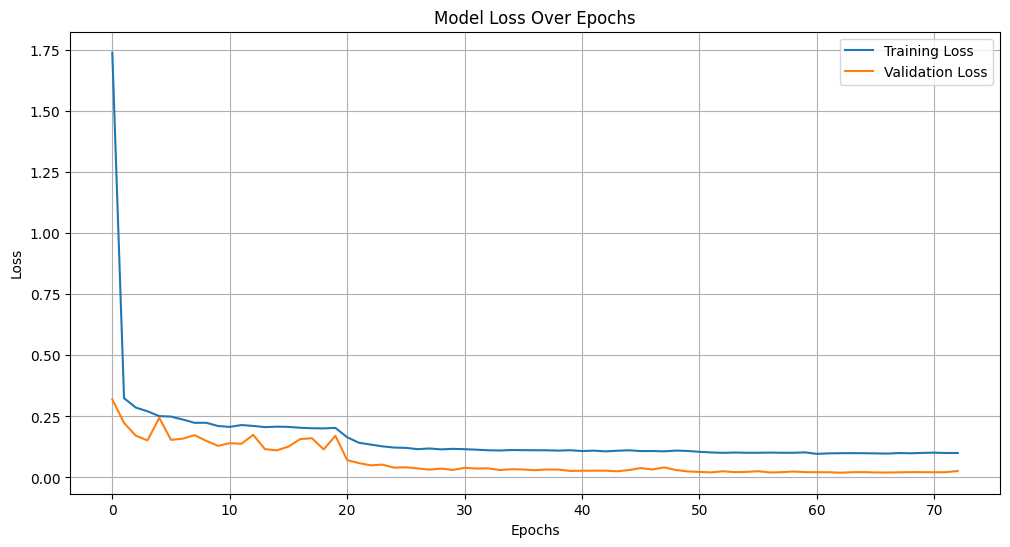

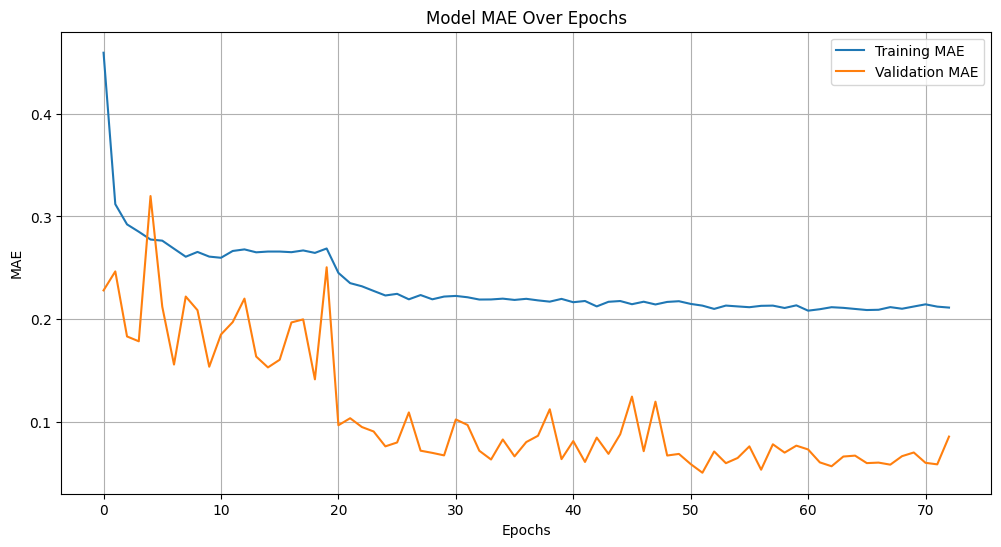

In [9]:
# Visualization
def plot_training_history(history):
    # Loss Plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # MAE Plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)

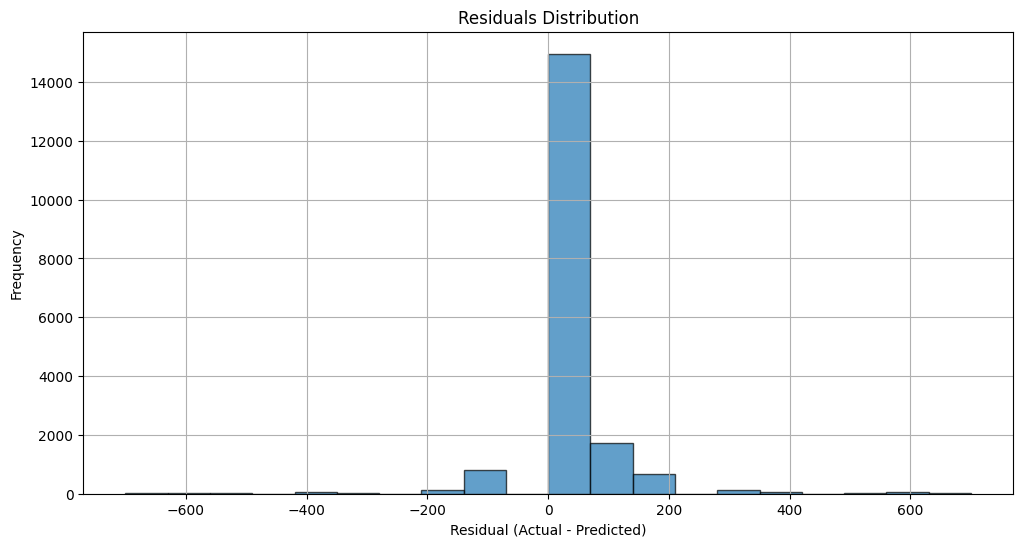

In [10]:
# Residuals Distribution
residuals = y_test_rounded - y_pred_rounded.flatten()
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
# Save Model Architecture to JSON
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

# Save Model Weights
model.save_weights("model1.weights.h5")

ValueError: The filename must end in `.weights.h5`. Received: filepath=model1.h5

# Testing

In [ ]:
# # import numpy as np
# import pandas as pd
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler

# # Load trained model and scalers (Ensure you load your trained model and scalers before using this)
# # Assuming 'model', 'scaler_X', and 'scaler_y' are already trained and saved models/scalers

# def test_model_interactively():
#     """
#     Prompt the user for input and predict daily_steps along with derived outputs.
#     """
#     print("Enter the following details for prediction:")

#     try:
#         # Gather inputs from the user
#         gender = int(input("Gender (0 for Male, 1 for Female): "))
#         height = float(input("Height (in cm): "))
#         weight = float(input("Weight (in kg): "))
#         age = int(input("Age (in years): "))
        
#         # Calculate BMI
#         bmi = weight / ((height / 100) ** 2)
#         target_weight = 22 * ((height / 100) ** 2)  # Assuming target BMI is 22
#         weight_adjustment = weight - target_weight
        
#         # Prepare input for the model
#         new_input = np.array([[gender, bmi, age]])  # 'bmi' is already calculated
#         new_input_scaled = scaler_X.transform(new_input)  # Scale input using the trained scaler
        
#         # Predict daily_steps (scaled)
#         predicted_steps_scaled = model.predict(new_input_scaled)
#         predicted_steps = scaler_y.inverse_transform(predicted_steps_scaled).flatten()[0]
        
#         # Determine BMI category
#         if bmi < 18.5:
#             bmi_category = "underweight"
#         elif 18.5 <= bmi < 24.9:
#             bmi_category = "normal"
#         elif 25 <= bmi < 29.9:
#             bmi_category = "overweight"
#         else:
#             bmi_category = "obese"
        
#         # Display results
#         print("\nPrediction Results:")
#         print(f"BMI: {bmi:.2f}")
#         print(f"Target Weight: {target_weight:.2f} kg")
#         print(f"Weight Adjustment: {weight_adjustment:.2f} kg")
#         print(f"Predicted Daily Steps: {predicted_steps:.0f}")
#         print(f"BMI Category: {bmi_category}")
    
#     except ValueError:
#         print("Invalid input. Please enter valid numbers.")

# # Run the interactive test
# test_model_interactively()